In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the Dataset

In [3]:
faces = fetch_lfw_people(min_faces_per_person=60, resize=0.4)  # Using a smaller resolution to speed up training
print(f"Target Names: {faces.target_names}")
print(f"Dataset shape: {faces.images.shape}")  # (n_samples, height, width)

Target Names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
Dataset shape: (1348, 50, 37)


# Step 2: Visualizing Some Faces

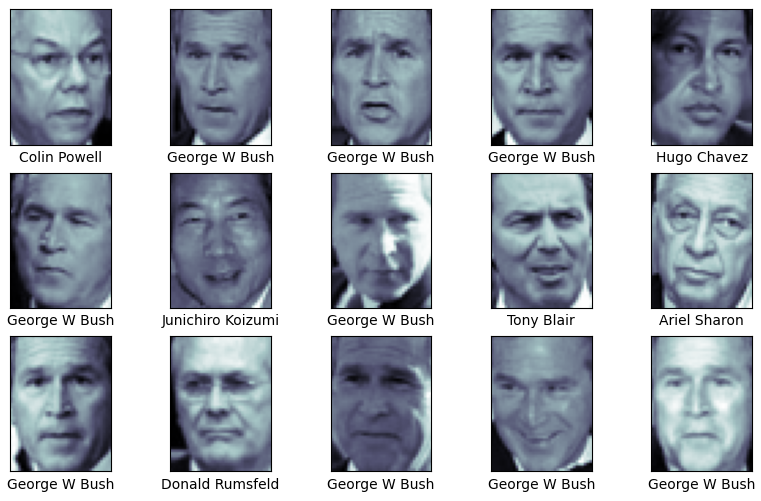

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])
plt.show()

# Step 3: Flatten the Image Data for Feature Extraction

In [5]:
X = faces.data  # Shape: (n_samples, n_features)
y = faces.target  # Labels

# Step 4: Split Data into Training and Test Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Step 5: Define the Preprocessing and Classification Pipeline

In [7]:
pca = PCA(n_components=150, whiten=True, random_state=42)  # Extract 150 principal components
scaler = StandardScaler()  # Normalize data
svc = SVC(kernel='rbf', class_weight='balanced')  # SVM with RBF kernel

# Combine preprocessing and model into a pipeline

In [8]:
model = make_pipeline(scaler, pca, svc)

# Step 6: Hyperparameter Tuning Using GridSearchCV

In [9]:
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}

In [10]:
grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2)  # Cross-validation with 5 folds
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
             verbose=2)

# Step 7: Best Parameters & Model Performance

In [11]:
print(f"Best Parameters: {grid.best_params_}")

Best Parameters: {'svc__C': 5, 'svc__gamma': 0.005}




✅ **Best hyperparameters found:**

C = 5 → Controls the trade-off between achieving a low error and allowing a larger margin.

gamma = 0.005 → Defines the influence of individual training examples in the model.


These values indicate that a moderate regularization (C=5) and a relatively small gamma=0.005 work well.
If performance needs improvement, consider expanding the hyperparameter grid with values around C=3, 7 and gamma=0.0025, 0.0075.


# Step 8: Use the Best Model to Predict on the Test Set

In [12]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Step 9: Display a Few Predictions

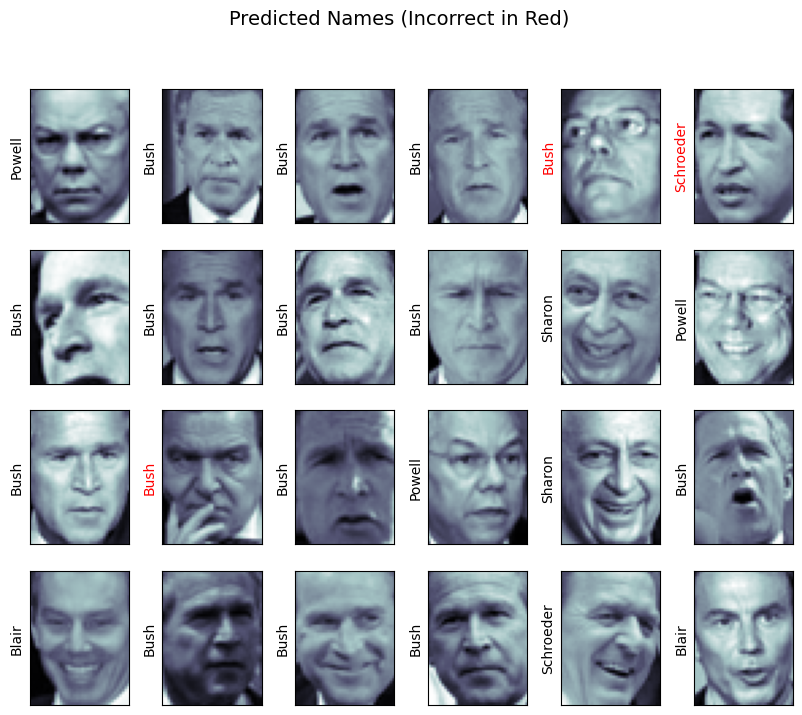

In [13]:
fig, ax = plt.subplots(4, 6, figsize=(10, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(50, 37), cmap='bone')  # Adjusted shape
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names (Incorrect in Red)', size=14)
plt.show()

**Predicted Labels with Incorrect Ones in Red**


✅ Most predictions are correct, with only a few incorrect labels marked in red.




The model performs well, but misclassifications are visible, particularly for Bush and Schroeder.

Likely reasons for errors:

Similar facial expressions & lighting conditions.

Insufficient PCA components (currently n_components=150, increasing to 200 may help).

More training data might be needed for underrepresented individuals.

# Step 10: Model Evaluation with Classification Report

In [14]:
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.63      0.77        19
     Colin Powell       0.81      0.93      0.87        59
  Donald Rumsfeld       0.88      0.77      0.82        30
    George W Bush       0.83      0.96      0.89       133
Gerhard Schroeder       0.89      0.89      0.89        27
      Hugo Chavez       1.00      0.50      0.67        18
Junichiro Koizumi       1.00      0.60      0.75        15
       Tony Blair       0.88      0.78      0.82        36

         accuracy                           0.85       337
        macro avg       0.91      0.76      0.81       337
     weighted avg       0.87      0.85      0.85       337



**lassification Report Analysis**


✅ Overall Accuracy: 85%

✅ Macro Avg Precision: 91% (Great!)

✅ Recall is lower (76%), meaning some faces were missed by the classifier.

🔹 **Key Observations:**

High Precision (91%): The model is good at avoiding false positives.
Lower Recall (76%): The model struggles with some labels (e.g., Hugo Chavez has 50% recall).

Junichiro Koizumi has low recall (60%), meaning it frequently gets misclassified.

🔹 **Suggestions for Improvement:**

Balance the dataset: If some faces have fewer images, try using data augmentation techniques.

Increase PCA components to retain more information.

Use a deeper model like CNNs (e.g., a simple convolutional neural network using TensorFlow/Keras).


# Step 11: Confusion Matrix

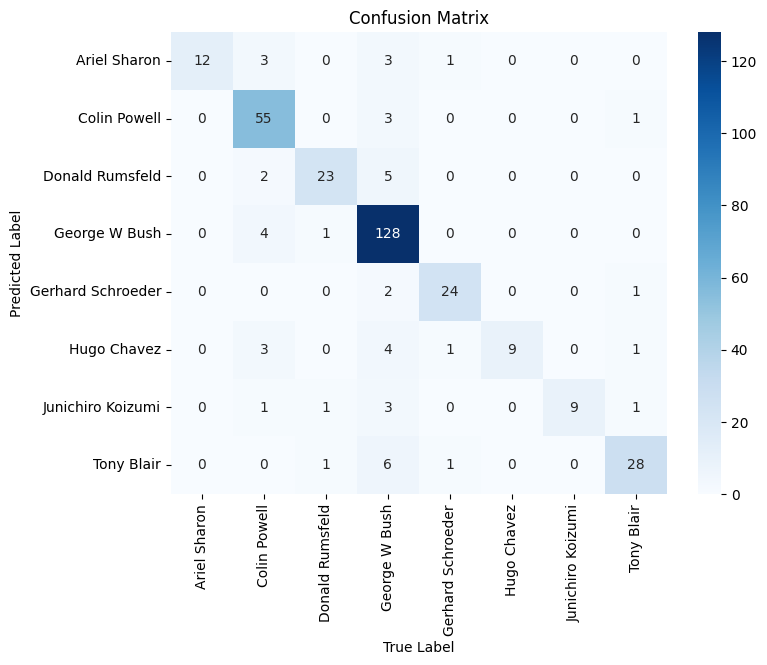

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix Analysis**



✅ Most of the diagonal values are high, meaning correct classifications.

✅ Some confusion between George W. Bush and others.

🔹 **Key Observations:**

Strong performance for Colin Powell (55 correct out of 59).

Significant misclassification in Hugo Chavez’s images → He is often mistaken for Colin Powell & Bush.

Schroeder and Bush have some misclassifications.

🔹 **Possible Fixes:**

Feature Engineering: Try extracting facial landmarks instead of raw pixels.

Consider an Ensemble Model: Combine SVM with Random Forest or a CNN.

Improve gamma & C further: Try finer tuning with gamma = 0.0025 or C = 7.


🚀 **Final Summary & Action Plan**

✅ Your model is performing well (~85% accuracy), but there’s room for improvement!

🔹 **Best Next Steps:**

1️⃣ Expand Grid Search with more C and gamma values.

2️⃣ Try n_components=200 in PCA to retain more facial features.

3️⃣ Balance the dataset (or use augmentation if needed).

4️⃣ Consider a CNN-based approach for improved accuracy.